# Data Preprocessing

## Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))

from dvc_helper import DvcHelper
from df_overview import DfOverview
from df_cleaner import DfCleaner
from df_outlier import DfOutlier
from vis_seaborn import VisSeaborn
from vis_plotly import VisPlotly

2021-07-27 20:36:39,965 — DfOverview — DEBUG — Loaded successfully!
2021-07-27 20:36:39,968 — DfCleaner — DEBUG — Loaded successfully!
2021-07-27 20:36:39,972 — DfOutlier — DEBUG — Loaded successfully!


In [4]:
sb = VisSeaborn()

## Load Data

In [5]:
dvc_helper = DvcHelper()

In [6]:
missing_values = ["n/a", "na", "undefined", float(np.nan)]

df_store = dvc_helper.read_csv('../data/store.csv', missing_values)
df_train = dvc_helper.read_csv('../data/train.csv', missing_values)
df_test = dvc_helper.read_csv('../data/test.csv', missing_values)

2021-07-27 20:36:40,320 — DfHelper — DEBUG — file read as csv
2021-07-27 20:36:40,800 — DfHelper — DEBUG — file read as csv
2021-07-27 20:36:40,830 — DfHelper — DEBUG — file read as csv


## Dataset Description

### Data fields:

- `Id` - an Id that represents a(Store, Date) duple within the test set
- `Store` - a unique Id for each store
- `Sales` - the turnover for any given day(this is what you are predicting)
- `Customers` - the number of customers on a given day
- `Open` - an indicator for whether the store was open: 0 = closed, 1 = open
- `StateHoliday` - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- `SchoolHoliday` - indicates if the(Store, Date) was affected by the closure of public schools
- `StoreType` - differentiates between 4 different store models: a, b, c, d
- `Assortment` - describes an assortment level: a = basic, b = extra, c = extended. Read more about assortment here
- `CompetitionDistance` - distance in meters to the nearest competitor store
- `CompetitionOpenSince[Month / Year]` - gives the approximate year and month of the time the nearest competitor was opened
- `Promo` - indicates whether a store is running a promo on that day
- `Promo2` - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- `Promo2Since[Year / Week]` - describes the year and calendar week when the store started participating in Promo2
- `PromoInterval` - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


### Information about data

Store data

In [7]:
print(df_store.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
None


We have total 1115 unique stores


Train data

In [8]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
None


As we can see here, we have around 1 million datapoints. The training period data ranges from 2013-01-01 to 2015-07-31.

Test data

In [9]:
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB
None


We have around 41000 datapoints for testing. The test period ranges from 2015-08-01 to 2015-09-17, so the task is to predict sales for 48 days.

## Clean Data

In [10]:
cleaner = DfCleaner()

### Missing value

Let's start by getting detailed overview the store data

In [11]:
store_overview = DfOverview(df_store)
store_overview.getOverview()

,count,none_count,none_percentage,unique_value_count,unique_percentage,dtype
label,,,,,,
Store,1115,0,0.0%,1115,100.0%,int64
StoreType,1115,0,0.0%,4,0.36%,object
Assortment,1115,0,0.0%,3,0.27%,object
Promo2,1115,0,0.0%,2,0.18%,int64
CompetitionDistance,1112,3,0.27%,654,58.65%,float64
CompetitionOpenSinceMonth,761,354,31.75%,12,1.08%,float64
CompetitionOpenSinceYear,761,354,31.75%,23,2.06%,float64
Promo2SinceWeek,571,544,48.79%,24,2.15%,float64
Promo2SinceYear,571,544,48.79%,7,0.63%,float64


In the store dataset, out of the 10 columns 6 have null value. Lets look at them one by one and decide what to do based on the data. There are only 3 missing values in `CompetitionDistance` and it holds continues numeric value. Since they are small we can impute them with median.

In [12]:
df_store = cleaner.fill_with_median(df_store, ['CompetitionDistance'])

Let's look into what data of `CompetitionOpenSinceMonth` and `CompetitionOpenSinceYear`.

In [13]:
print(np.sort(df_store['CompetitionOpenSinceMonth'].unique()))
print(np.sort(df_store['CompetitionOpenSinceYear'].unique()))

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. nan]
[1900. 1961. 1990. 1994. 1995. 1998. 1999. 2000. 2001. 2002. 2003. 2004.
 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.   nan]


Columns `CompetitionOpenSinceMonth` and `CompetitionOpenSinceYear` hold the year and month when  a new compitition opened. Since there is `CompetitionDistance` for all columns 
time when new compitition is started. 
Here both `CompetitionOpenSinceMonth` and `CompetitionOpenSinceYear` having null value is meaning full. It means competition for a store has already been there before the store is established or there is no compitition. 

The longest time we have in the dataset is 1900. So I have replaced the None values with
first month 1990.

In [14]:
df_store['CompetitionOpenSinceMonth'] = df_store['CompetitionOpenSinceMonth'].fillna(1)
df_store['CompetitionOpenSinceYear'] = df_store['CompetitionOpenSinceYear'].fillna(1990)


Now we are left with three columns. `Promo2SinceWeek`, `Promo2SinceYear` and `PromoInterval`. All of this columns have a null percentage of 48.79 % . Let's look into what data they are holding.


In [15]:
print(np.sort(df_store['Promo2SinceWeek'].unique()))
print(np.sort(df_store['Promo2SinceYear'].unique()))
print(df_store['PromoInterval'].unique())

[ 1.  5.  6.  9. 10. 13. 14. 18. 22. 23. 26. 27. 28. 31. 35. 36. 37. 39.
 40. 44. 45. 48. 49. 50. nan]
[2009. 2010. 2011. 2012. 2013. 2014. 2015.   nan]
[nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']


In [16]:
df_store[df_store['Promo2'] == 0][['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']].head(5)

,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN


 As we can see, this three columns dependent on Promo2, and the reason for mesing value is because Promo2 is equal to 0. The porblem is we can not store this information in a month or a year. So we will create a new column holding if the store participated on promo2. then we can
 replace `Promo2SinceYear` and `Promo2SinceWeek` with the earliest month and week. 


In [17]:
print(pd.isnull(df_store['PromoInterval'][0]))

True


In [18]:
df_store['Promo2SinceWeek'] = df_store['Promo2SinceWeek'].fillna(0)
df_store['Promo2SinceYear'] = df_store['CompetitionOpenSinceYear'].fillna(0)

Entries in `PromotionInterval` have 4 entries. We will split those points into 4 columns

In [19]:
month_abbr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
def getMonth(months, index):
  if(months == 0):
    return 0

  month = months.split(',')[index]
  return month_abbr.index(month)+1

In [20]:
df_store['PromoInterval'] = df_store['PromoInterval'].fillna(0)
df_store['PromoInterval0'] = df_store.PromoInterval.apply((lambda x: getMonth(x, 0)))
df_store['PromoInterval1'] = df_store.PromoInterval.apply((lambda x: getMonth(x, 1)))
df_store['PromoInterval2'] = df_store.PromoInterval.apply((lambda x: getMonth(x, 2)))
df_store['PromoInterval3'] = df_store.PromoInterval.apply((lambda x: getMonth(x, 3)))
df_store = cleaner.drop_columns(df_store, ['PromoInterval'])

Lets check our work

In [21]:
store_overview = DfOverview(df_store)
store_overview.missing_value()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Now lets look at training data

In [22]:
train_overview = DfOverview(df_train.copy())
train_overview.getOverview()[:10]

,count,none_count,none_percentage,unique_value_count,unique_percentage,dtype
label,,,,,,
Store,1017209,0,0.0%,1115,0.11%,int64
DayOfWeek,1017209,0,0.0%,7,0.0%,int64
Date,1017209,0,0.0%,942,0.09%,object
Sales,1017209,0,0.0%,21734,2.14%,int64
Customers,1017209,0,0.0%,4086,0.4%,int64
Open,1017209,0,0.0%,2,0.0%,int64
Promo,1017209,0,0.0%,2,0.0%,int64
StateHoliday,1017209,0,0.0%,5,0.0%,object
SchoolHoliday,1017209,0,0.0%,2,0.0%,int64


The training data is perfect. No Null values. This can't be coincedence, I think this data is cleaned before.

In [23]:
test_overview = DfOverview(df_test)
test_overview.getOverview()

,count,none_count,none_percentage,unique_value_count,unique_percentage,dtype
label,,,,,,
Id,41088,0,0.0%,41088,100.0%,int64
Store,41088,0,0.0%,856,2.08%,int64
DayOfWeek,41088,0,0.0%,7,0.02%,int64
Date,41088,0,0.0%,48,0.12%,object
Promo,41088,0,0.0%,2,0.0%,int64
StateHoliday,41088,0,0.0%,2,0.0%,object
SchoolHoliday,41088,0,0.0%,2,0.0%,int64
Open,41077,11,0.03%,2,0.0%,float64


This is also almost perfect. Only 11 entries in `Open` column are null. 
We can't drop them becouse we are required to use them. 

In [24]:
df_test[pd.isnull(df_test['Open'])]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


All the Nane values are form store 622. Lets look for store 622 in the training dataset.

In [25]:
unknown_date = df_test[pd.isnull(df_test['Open'])]['Date'].values
temp_df = df_train[df_train['Store'] == 622]
[cols for cols in df_train['Store'] if cols in unknown_date]


[]

Unfortunatelly there is no record in training set about the 622 on this days. 
Our last option is to do fill forward and hope for the best.

In [26]:
df_test = cleaner.fix_missing_ffill(df_test, ['Open'])

In [27]:
test_overview = DfOverview(df_test)
test_overview.missing_value()

[0, 0, 0, 0, 0, 0, 0, 0]

## Removing points with zero Sales:


In [28]:
closed_store_count = df_train[(df_train.Open == 0) & (df_train.Sales == 0)].shape[0]
print(f"Closed stores count: {closed_store_count}")
print(f"Closed stores percentage: {(closed_store_count/df_train.shape[0]*100):.4}%", )

Closed stores count: 172817
Closed stores percentage: 16.99%


As we can see around 17% percent of the stores are closed but I won't drop them because
we will use it in data exploration. 

In [29]:
closed_store_count = df_test[(df_test.Open == 0)].shape[0]
closed_store_count
df_test.shape[0]

41088

## Outlier treating

As before we will start with the store data. Here the only column we should consider is `CompetitionDistance` because the others have fewer unique values.

In [30]:
df_outliers = DfOutlier(df_store[['CompetitionDistance']].copy())
overview = df_outliers.getOverview()
overview

,number_of_outliers,percentage_of_outliers,skew,Q1,Median,Q3
label,,,,,,
CompetitionDistance,108,9.69%,2.93,720.00,2325.00,6875.00


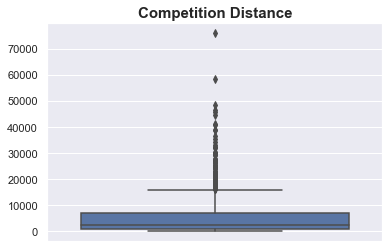

In [31]:
sb.boxplot(df_store, ['CompetitionDistance'], 'Competition Distance', figsize=(6, 4))

In [32]:
df_outliers = DfOutlier(df_store)
df_outliers.replace_outliers_with_iqr(['CompetitionDistance'])
df_store = df_outliers.df

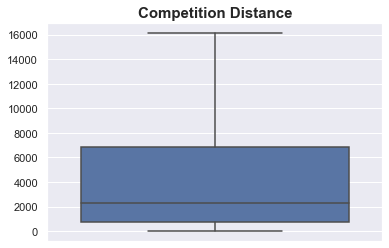

In [33]:
sb.boxplot(df_store, ['CompetitionDistance'], 'Competition Distance', figsize=(6, 4))

Now lets look at the training data. Here we should consider `Sales` and `Customers`.

In [34]:
df_outliers = DfOutlier(df_train[['Sales', 'Customers']].copy())
overview = df_outliers.getOverview()
overview

,number_of_outliers,percentage_of_outliers,skew,Q1,Median,Q3
label,,,,,,
Sales,26694,2.62%,0.64,3727.00,5744.00,7856.00
Customers,38095,3.75%,1.60,405.00,609.00,837.00


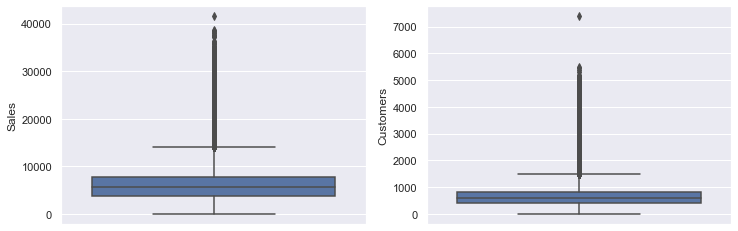

In [35]:
sb.boxplot(df_train, ['Sales', 'Customers'], cols=2, figsize=(12, 4))

In [36]:
df_outliers = DfOutlier(df_train)
df_outliers.replace_outliers_with_iqr(['Sales', 'Customers'])
df_train = df_outliers.df

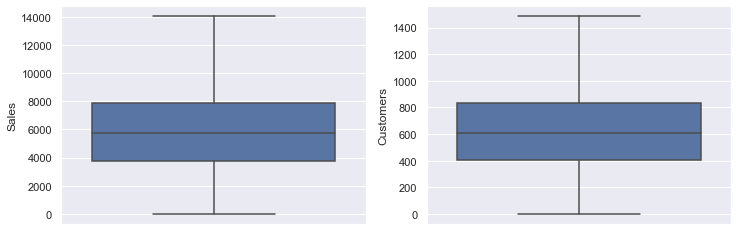

In [37]:
sb.boxplot(df_train, ['Sales', 'Customers'], cols=2, figsize=(12, 4))

## Fix Data types

First we convert the date data into datetime.

In [38]:
df_train = cleaner.convert_to_datetime(df_train, ['Date'])
df_test = cleaner.convert_to_datetime(df_test, ['Date'])

convert categorical columns to string

In [39]:
df_train["StateHoliday"].loc[df_train["StateHoliday"] == 0] = "0"
df_test["StateHoliday"].loc[df_test["StateHoliday"] == 0] = "0"

In [40]:
df_store = cleaner.convert_to_string(df_store, ['StoreType', 'Assortment'])
df_train = cleaner.convert_to_string(df_train, ['StateHoliday', 'SchoolHoliday'])
df_test = cleaner.convert_to_string(df_test, ['StateHoliday', 'SchoolHoliday'])

convert descrete values to int

In [41]:
df_store = cleaner.convert_to_integer(df_store, ['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear'])
df_train = cleaner.convert_to_integer(df_train, ['Customers', 'Sales', 'Open'])
df_test = cleaner.convert_to_integer(df_test, ['Open'])

KeyError: 'WasInPromo2'

## Save cleaned data


In [ ]:
dvc_helper.save_csv(df_store, '../data/clean_store.csv')
dvc_helper.save_csv(df_train, '../data/clean_train.csv')
dvc_helper.save_csv(df_test, '../data/clean_test.csv')

2021-07-27 19:07:01,221 — DfHelper — INFO — file saved as csv
2021-07-27 19:07:13,136 — DfHelper — INFO — file saved as csv
2021-07-27 19:07:13,579 — DfHelper — INFO — file saved as csv
